# Fluorescence polarization

In [1]:
from io import StringIO
from pathlib import Path
from itertools import repeat
from operator import itemgetter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Read data

In [2]:
folder = Path("data/fluorescence-polarization")  # specify path to your data

In [3]:
def read(csv_file: Path):
    content = csv_file.read_text()
    data = content.partition("\n\n")[0]
    file = StringIO(data)
    df = pd.read_csv(
        file, skiprows=2, names=["wavelength", "intensity"], usecols=[0, 1]
    )
    return df

In [4]:
def get_data(folder: Path):
    d = {}
    for p in folder.glob("*.csv"):
        d[p.stem] = read(p)
    return pd.Series(d)

In [5]:
all_data = get_data(folder).sort_index()

## Curve fitting

In [6]:
def peak(x: np.array, A=1, mu=0, sigma=1):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

In [7]:
def objective(x, *params):
    params = np.array(params).flatten()
    shape = int(len(params) / 3), 3
    peaks = np.reshape(params, shape)
    return sum(peak(x, A, mu, sigma) for A, mu, sigma in peaks)

In [8]:
def fit_peaks(sr: pd.Series, mus, range=None, internal_sample=100):
    x = sr.index
    y = sr.values
    inits = zip(repeat(1), mus, repeat(1))
    p0 = [p for z in inits for p in z]  # flattenize

    popt, pcov = curve_fit(objective, x, y, p0=p0)
    return np.split(popt, len(popt) / 3)

## Plot

In [9]:
def peak_analysis(all_data):

    fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10, 10))
    
    intensities = {}
    peaks = {}

    Z = zip(range(1, len(all_data) + 1), all_data.items(), axs.ravel())

    for i, (k, data), ax in Z:

        # find main peak
        data.plot(x=0, y=1, ax=ax)

        smooth = gaussian_filter1d(data.intensity, 2)  # smoothing factor
        [peak_idx], _ = find_peaks(smooth, 1)  # should be only 1, increase smoothing factor
        data.iloc[[peak_idx]].plot(x=0, y=1, style=".r", ax=ax)
        wl, int_ = data.iloc[peak_idx]

        title = "№ {no} : $\lambda = {wl:.0f}$, $I_{{{idxs}}} = {int:.2f}$".format(
            no=k[0], wl=wl, idxs=",".join(k[1:]), int=int_
        )

        ax.set_title(title)
        ax.get_legend().remove()

        intensities[(k[0], k[1:])] = int_

        # peak decomposition
        sr = data.set_index("wavelength").intensity
        minmax = sr.index.min(), sr.index.max()

        sr.plot(ax=ax)
        x = np.linspace(*minmax, 1000)

        pks = fit_peaks(sr, [500, 540])  # adjust wavelengths
        peaks[(k[0], k[1:])] = pks
        ax.plot(x, objective(x, *pks), "r", alpha=0.5)
        [ax.plot(x, peak(x, *parms), "--", alpha=0.5) for parms in pks]

    plt.tight_layout()

    yield pd.Series(intensities).unstack(level=1)  # intensities

    def prepare_peaks(sr: dict):
        result = {}
        for k, vals in peaks.items():
            for A, mu, sigma in vals:
                result[(*k, mu)] = {'sigma': sigma, 'A': A}
        df = pd.DataFrame(result).T
        df.index.names = [None, None, 'mu']
        return df.sort_index()

    yield prepare_peaks(peaks)

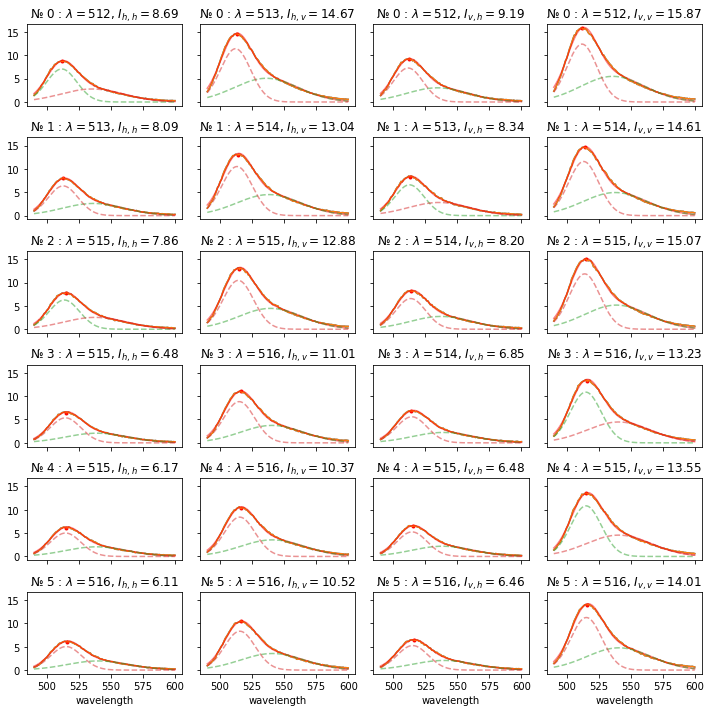

In [10]:
intensities, peaks = peak_analysis(all_data)

In [11]:
intensities["g_factor"] = intensities.hv / intensities.hh
intensities["polarization"] = intensities.apply(
    lambda x: (x.vv - x.g_factor * x.vh) / (x.vv + x.g_factor * x.vh), axis=1
)

In [12]:
intensities

hh         hv        vh         vv  g_factor  polarization
0  8.692522  14.668288  9.187510  15.867807  1.687461      0.011611
1  8.085460  13.035077  8.340162  14.611181  1.612163      0.041540
2  7.856707  12.878545  8.202553  15.067453  1.639178      0.056887
3  6.478344  11.011899  6.853699  13.229930  1.699802      0.063505
4  6.167875  10.369456  6.478917  13.547698  1.681204      0.108646
5  6.111468  10.518697  6.460008  14.011591  1.721141      0.115121

In [13]:
peaks

sigma           A
     mu                               
0 hh 511.644990  11.778944  208.803195
     535.324647  24.542726  171.207778
  hv 512.053716  11.786603  337.168043
     535.985115  25.104754  319.471076
  vh 511.513513  11.565836  211.027115
     534.522378  24.261785  184.710001
  vv 511.992314  11.717146  364.241755
     536.028701  25.112217  345.677411
1 hh 512.742981  11.641281  185.545447
     536.390595  24.280124  158.573596
  hv 513.232314  11.925300  314.189148
     538.107781  24.892846  280.970015
  vh 512.587206  11.553473  190.866237
     535.584686  24.002905  169.243490
  vv 513.270031  11.848639  344.185936
     537.865414  25.170668  312.049280
2 hh 513.640995  11.876015  186.332213
     537.636525  24.335133  154.788549
  hv 514.210419  11.934084  312.865764
     539.234358  24.983530  279.481123
  vh 513.526196  11.659337  191.994157
     537.210313  24.224574  166.332385
  vv 514.092660  11.973688  355.750216
     538.826850  25.044826  324.644349
3 hh 514.535823  12.015150  161.279764
     539.078998  24.428095  126.508535
  hv 514.923531  12.035761  266.280281
     540.524314  24.795034  232.028603
  vh 514.407662  11.952260  167.283368
     538.807939  24.053124  134.165140
  vv 514.922610  12.132724  330.370071
     540.613616  25.109393  281.278767
4 hh 514.659390  11.976600  150.594801
     538.683910  24.178784  125.240663
  hv 515.309895  11.988821  253.136911
     540.754349  24.944075  222.226409
  vh 514.580871  11.747674  154.845512
     538.399596  23.957030  131.477180
  vv 515.156919  12.038663  326.992293
     540.593231  25.106835  287.612671
5 hh 515.070423  12.110722  153.034928
     540.029218  24.137626  118.463911
  hv 515.419967  12.015015  250.650706
     540.856787  24.880198  221.318907
  vh 515.058931  12.084276  159.080661
     539.488086  24.417074  126.246799
  vv 515.418936  12.086628  341.024340
     540.800892  25.104701  300.043196